<a href="https://colab.research.google.com/github/pranay8297/fastaip2/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch==2.1.0
!pip install datasets
!pip install ipdb
!pip install torcheval
!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install diffusers
!pip install tqdm
!pip install accelerate

In [ ]:
from miniai.datasets import *
from miniai.activations import *
from miniai.learner import *
from miniai.augment import *
from miniai.activations import *
from miniai.init import *

from datasets import load_dataset
from torch.utils.data import DataLoader, DataLoaders, Dataset

import torch
import math
import numpy as np

from torch import nn
from torch.nn import functional as F
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
from ipdb import set_trace as st
from functools import partial
from torch import optim
from torch.optim import lr_scheduler

from torchvision import transforms
from pathlib import Path
from tqdm import tqdm

from torch.cuda.amp import GradScaler
from torch import autocast
import time
import numpy
from accelerate import Accelerator
import requests
import io
from PIL import Image

In [4]:
url = 'https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/d1/bb/d1bbf47d-256a-4833-b57c-eeb71a48b0bd/mona.jpg'

In [5]:
def load_image(uri, target_size = (512, 512)):
  image = Image.open(io.BytesIO(requests.get(url).content)).resize(target_size)
  content_im = transforms.PILToTensor()(image)
  if float(content_im.max()) > 1.: content_im = (content_im - content_im.min())/(content_im.max() - content_im.min())
  return content_im

In [6]:
content_im = load_image(url)

<Axes: >

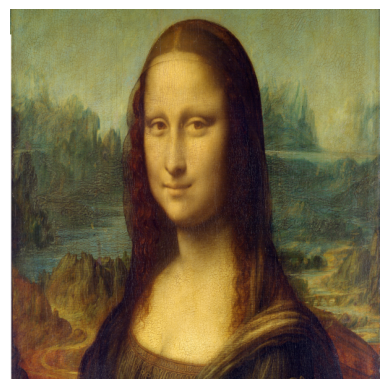

In [7]:
show_image(content_im)

In [8]:
content_im.max(), content_im.min(), content_im.mean(), content_im.std()

(tensor(1.), tensor(0.), tensor(0.3484), tensor(0.1991))

In [9]:
from torch.utils.data import Dataset

In [41]:
class DummyDS(Dataset):
  def __init__(self, n = 100, y = content_im): self.n = n; self.y = y
  def __len__(self): return self.n
  def __getitem__(self, index): return 0., self.y

def get_dummy_dls(n = 100): return DataLoaders(DataLoader(DummyDS(100), batch_size = 1), DataLoader(DummyDS(20), batch_size = 1))

In [42]:
dls = get_dummy_dls()

In [45]:
x, y = next(iter(dls.train))
y.shape

torch.Size([1, 3, 512, 512])

In [47]:
class StyleTransferModel(nn.Module):
  def __init__(self, w = None, size = (1, 3, 512, 512)):
    super().__init__()
    self.w = nn.Parameter(w.clone()) if w is not None else nn.Parameter(torch.randn(size))

  def forward(self, x):
    return self.w

In [60]:
loss_func = nn.MSELoss()

In [105]:
class ImageMonitoringCB(Callback):
  ProgressCB.order += 1
  def __init__(self, log_every = 20):
    self.log_every = log_every
    self.preds = []
    self.i = 0

  def after_batch(self, learn):
    if not learn.training: return
    if self.i%self.log_every == 0: self.preds.append(learn.preds.detach().clone().squeeze())
    self.i += 1

In [106]:
model = StyleTransferModel(w = torch.rand_like(y))
cbs = [MetricsCB(), ProgressCB(plot = False), ImageMonitoringCB()]
learner = TrainLearner(model, dls, loss_func, lr = 1e-02, opt_func = optim.AdamW, cbs = cbs)

In [107]:
learner.fit(1)

loss,epoch,train
0.031,0,train
0.001,0,eval


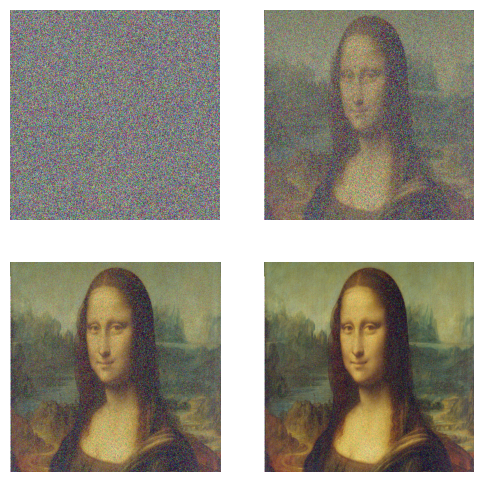

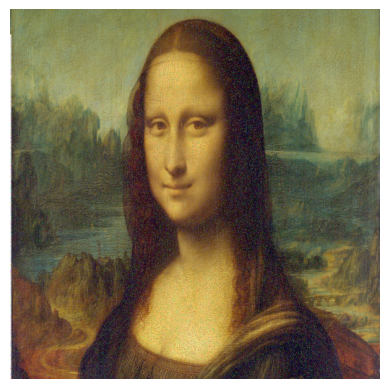

In [108]:
show_images(cbs[-1].preds)

In [109]:
import timm

In [ ]:
timm.list_models('*vgg*')

In [ ]:
timm.create_model('vgg16', pretrained= True).features,

In [162]:
def store_hooks(mod, inp, out, obj): obj.data = out

class Hook:
  def __init__(self, module):
    self.data = None
    self.module = module
    self.module.register_forward_hook(partial(store_hooks, obj = self))

class PerceptLoss():
  def __init__(self, layers = (18, 25), metric = nn.MSELoss(), device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    self.device = device
    self.net = timm.create_model('vgg16', pretrained= True).features
    self.means = torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
    self.std = torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)
    self.hooks = [Hook(self.net[i]) for i in layers]
    self.metric = metric

  def normalize(self, data): return (data - self.std)/self.means
  def __call__(self, yhat, y):
    loss = 0.
    out = self.net(self.normalize(torch.cat([yhat, y], dim = 0)))
    for i in [self.metric(i.data[0], i.data[1]) for i in self.hooks]: loss += i
    return loss

In [155]:
loss_func = PerceptLoss()
mod = StyleTransferModel()

In [156]:
l = loss_func(mod.w, y)

In [157]:
l

tensor(6.3051, grad_fn=<AddBackward0>)

In [158]:
l.backward()

In [161]:
mod.w.grad

tensor([[[[-5.4593e-05, -2.5615e-05,  2.9994e-04,  ...,  4.9643e-04,
            3.5471e-04,  5.5964e-05],
          [-1.1988e-04, -2.9549e-04, -6.2409e-04,  ...,  7.0129e-04,
            1.3192e-03,  3.7993e-04],
          [ 6.1021e-05, -2.8263e-04, -4.6068e-04,  ...,  1.0081e-03,
            8.8108e-04,  2.1001e-04],
          ...,
          [ 9.4618e-04,  2.3059e-03,  9.4368e-04,  ...,  2.8537e-04,
            2.0065e-04, -2.0834e-04],
          [ 4.3743e-04,  1.5530e-04,  1.6141e-03,  ...,  5.2822e-04,
            4.8858e-04, -3.0984e-04],
          [ 1.3341e-04, -2.1177e-04,  3.8114e-05,  ...,  5.2946e-04,
            5.7094e-04, -3.2690e-05]],

         [[ 8.5637e-05,  4.4255e-04,  7.1460e-04,  ...,  2.6902e-04,
            3.3123e-04,  3.1880e-04],
          [ 2.5002e-04,  4.2069e-04, -3.8113e-04,  ..., -1.0434e-03,
           -1.0842e-05,  6.7322e-05],
          [ 1.8210e-04, -1.4502e-04, -4.9733e-04,  ..., -2.1398e-03,
           -1.5105e-03, -4.6815e-04],
          ...,
     